In [1]:
import numpy as np
import cv2
import scipy
import matplotlib.pyplot as plt
from Utils.Utils import *

In [73]:
BasePath = '/home/sakshi/courses/ENPM673/sakshi_p1/'
SavePath = BasePath + "Results/problem1/"
video_file = BasePath + "Data/Tag2.mp4"
cap = cv2.VideoCapture(video_file)
frame_index = 302

i = 0
while(True):
    ret, frame = cap.read()
    if not ret:
        print("Stream ended..")
        break
    i = i + 1
    if i == frame_index:
        chosen_frame = frame
    cv2.imshow('frame',frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
i = frame_index


Stream ended..


In [74]:
def createCircularMask(image_size, radius, high_pass = True):
    rows, cols = image_size
    centre_x, centre_y = int(rows / 2), int(cols / 2)
    center = [centre_x, centre_y]
    x, y = np.ogrid[:rows, :cols]
    mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= radius*radius

    if high_pass:
        mask = np.ones((rows, cols)) 
        mask[mask_area] = 0
    else:
        mask = np.zeros((rows, cols)) 
        mask[mask_area] = 1

    return mask

In [75]:
def findContour(image):
    ret,thresh = cv2.threshold(np.uint8(image), 200 ,255,cv2.THRESH_BINARY)
    plt.imshow(thresh, cmap = 'gray')
    plt.savefig(SavePath + "thresh" + str(i) + ".jpg")
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    chosen_contours = []
    print(len(contours))
    print(hierarchy)
    for j in range(len(contours)):
        if hierarchy[0, j, 3] == -1:#no parent
            if hierarchy[0, j, 2] !=-1: #child
                print("no parent, child present")
                chosen_contours.append(contours[j])

    return chosen_contours  

In [76]:
def findCornersFromContour(contour):
    x_min, y_min = np.min(contour, axis = 0)
    x_max, y_max = np.max(contour, axis = 0)
    index1 = np.where(contour[:,0] == x_min) #topmost point
    index1 = index1[0]
    index1 = index1[0]
    x1 = contour[index1,0]
    y1 = contour[index1,1]

    index2 = np.where(contour[:,1] == y_max) #right most point
    index2 = index2[0]
    index2 = index2[0]
    x2 = contour[index2, 0]
    y2 = contour[index2, 1]

    index3 = np.where(contour[:,0] == x_max) #bottommost point
    index3 = index3[-1]
    index3 = index3[-1]
    x3 = contour[index3, 0]
    y3 = contour[index3, 1]

    index4 = np.where(contour[:,1] == y_min) #leftmost point
    index4 = index4[-1]
    index4 = index4[-1]
    x4 = contour[index4, 0]
    y4 = contour[index4, 1]

    corner = np.array([[x1, y1], [x2, y2], [x3, y3], [x4, y4]])
    return corner

In [77]:
def extractInfoFromTag(tag):

    tag_size = tag.shape[0]
    grid_size = 8
    pixels_in_one_grid =  int(tag_size/8)

    info_with_padding = np.zeros((8,8))

    for i in range(0, grid_size, 1):
        for j in range(0, grid_size, 1):
            grid = tag[i*pixels_in_one_grid:(i+1)*pixels_in_one_grid, j*pixels_in_one_grid:(j+1)*pixels_in_one_grid]
            
            if np.sum(grid) > 100000*0.7 and np.median(grid) == 255:
                print(np.sum(grid))
                info_with_padding[i,j] = 255
    print(info_with_padding)
    info = info_with_padding[2:6, 2:6]
    return info

In [78]:
def decipherInfoFromTag(info):
    while not info[3,3]:
        info = np.rot90(info, 1)

    print(info)
    id_info = info[1:3, 1:3]
    id_info_flat = np.array([id_info[0,0], id_info[0,1], id_info[1,1], id_info[1,0]])
    tag_id = 0
    for i in range(4):
        if(id_info_flat[i]):
            tag_id = tag_id + 2**i
    return tag_id

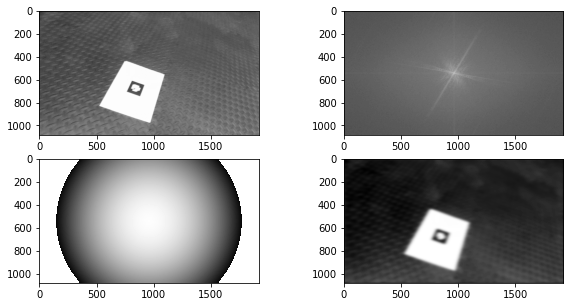

In [79]:
#gray image

image = chosen_frame
image_color = image.copy()
image_true = image.copy()
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#fft
fft = scipy.fft.fft2(image_gray, axes = (0,1))
fft_shifted = scipy.fft.fftshift(fft)
magnitude_spectrum_fft_shifted = 20*np.log(np.abs(fft_shifted))

#fft+mask
fft_masked = fft_shifted * createGaussianMask(image_gray.shape, 30, 30)
magnitude_spectrum_masked= 20*np.log(np.abs(fft_masked))

#image back
img_back = scipy.fft.ifftshift(fft_masked)
img_back = scipy.fft.ifft2(img_back)
img_back = np.abs(img_back)

fx, plts = plt.subplots(2,2,figsize = (10,5))
plts[0][0].imshow(image_gray, cmap = 'gray')
plts[0][1].imshow(magnitude_spectrum_fft_shifted, cmap = 'gray')
plts[1][0].imshow(magnitude_spectrum_masked, cmap = 'gray')
plts[1][1].imshow(img_back, cmap = 'gray')


plt.savefig(SavePath + "fft" + str(i) + ".jpg")

3
[[[-1 -1  1 -1]
  [-1 -1  2  0]
  [-1 -1 -1  1]]]
no parent, child present


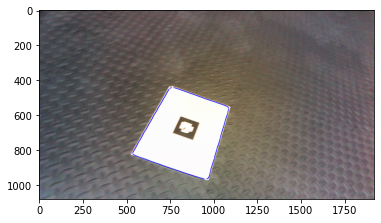

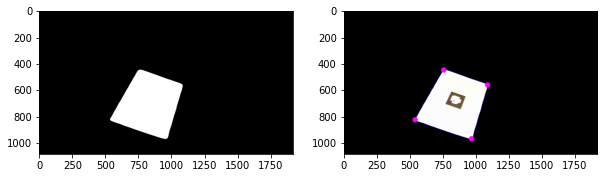

In [80]:
chosen_contours = findContour(img_back)

out_mask = np.zeros_like(image_gray)
corners = []
for chosen_contour in chosen_contours:
    # rect = cv2.minAreaRect(chosen_contour)
    # corner = cv2.boxPoints(rect)
    #corner = findCornersFromContour(chosen_contour.reshape(-1,2))
    corner = cv2.approxPolyDP(chosen_contours[0], 0.009 * cv2.arcLength(chosen_contours[0], True), True) 
    #corner = cv2.convexHull(corner1)
    #corner = np.int0(corner)
    corners.append(corner.reshape(-1,2))
    cv2.drawContours(image_color, chosen_contour, -1, (0, 0 ,255), 3)
    cv2.drawContours(out_mask, [chosen_contour], -1, 1, cv2.FILLED)    


out_mask_mul = np.dstack((out_mask, out_mask, out_mask))
detected_april_tag = image_color * out_mask_mul
for c in corners:
    for r in range(c.shape[0]):
        x,y = c[r,:]
        cv2.circle(detected_april_tag,(x,y),20,(255, 0, 255),-1) 

plt.imshow(image_color)
plt.savefig(SavePath + "contour" + str(i) + ".jpg")

fx, plts = plt.subplots(1,2,figsize = (10,7))
plts[0].imshow(out_mask, cmap = 'gray')
plts[1].imshow(detected_april_tag)
plt.savefig(SavePath + "detect" + str(i) + ".jpg")


In [81]:
def arrangeCorners(corners):
    #leftmost poin
    dist = np.square(corners[:,0]) + np.square(corners[:,1])
    arrnged_corners = []

    for i in range(corners.shape[0]):
        index = np.argmax(dist)
        arrnged_corners.append(corners[index,:])
        dist[index] = -1

    temp = arrnged_corners[2].copy()
    arrnged_corners[2] = arrnged_corners[-1]
    arrnged_corners[3] = temp

    return np.array(arrnged_corners)

In [82]:
def applyHomography2ImageUsingInverseWarpingNew(image, H, size):

    Xt, Yt = np.indices((size[0], size[1]))
    lin_homg_pts_trans = np.stack((Xt.ravel(), Yt.ravel(), np.ones(Xt.size)))

    H_inv = np.linalg.inv(H)
    lin_homg_pts = H_inv.dot(lin_homg_pts_trans)
    lin_homg_pts /= lin_homg_pts[2,:]

    X_min = np.min(lin_homg_pts[0,:]).astype(int)
    Y_min = np.min(lin_homg_pts[1,:]).astype(int)
    X_max = np.max(lin_homg_pts[0,:]).astype(int)
    Y_max = np.max(lin_homg_pts[1,:]).astype(int)
    X_min, X_max, Y_min, Y_max

    #pad image
    max_val = np.max([X_max, image.shape[0], Y_max, image.shape[1]])
    image_i = np.zeros((max_val, max_val, 3))
    print(image_i.shape)
    image_i[0:image.shape[0], 0:image.shape[1], :] = image

    image_transformed = np.zeros((size[0], size[1], 3))
    Xi, Yi = lin_homg_pts[:2,:].astype(int)
    image_transformed[Xt.ravel(), Yt.ravel(), :] = image_i[Yi, Yi, :]
    
    return image_transformed


(1920, 1920, 3)


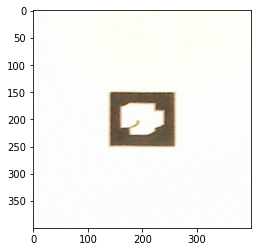

In [85]:
size_x = 400
size_y = 400

corner1 = arrangeCorners(corners[0])
corner2 = arrangeCorners(np.array([ [0, size_y], [size_x, size_y], [size_x, 0], [0, 0]]))

H = computeHomography(np.float32(corner1), np.float32(corner2))
#image_transformed = cv2.warpPerspective(image, H, (size_x, size_y))
image_transformed = applyHomography2ImageUsingInverseWarping(image, H, (size_x, size_y))

plt.imshow(np.uint8(image_transformed))
plt.savefig(SavePath + "img_trans" + str(i) + ".jpg")


In [86]:
corner1, corner2

(array([[ 964,  964],
        [1085,  558],
        [ 753,  445],
        [ 537,  821]], dtype=int32),
 array([[400, 400],
        [  0, 400],
        [  0,   0],
        [400,   0]]))

no parent, child present


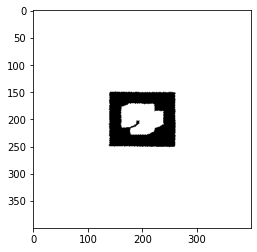

In [87]:
image_transformed_gray = cv2.cvtColor(np.uint8(image_transformed), cv2.COLOR_BGR2GRAY)
ret,thresh = cv2.threshold(image_transformed_gray, 200 ,255,cv2.THRESH_BINARY)
plt.imshow(thresh, cmap = 'gray')
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
chosen_contours = []
# print(len(contours))
# print(hierarchy)
for j in range(len(contours)):
    if hierarchy[0, j, 3] == 0:#no parent
        if hierarchy[0, j, 2] !=-1: #child
            print("no parent, child present")
            chosen_contours.append(contours[j])


In [88]:
tag_size = 160
tag_corner = cv2.approxPolyDP(chosen_contours[0], 0.009 * cv2.arcLength(chosen_contours[0], True), True) 
desired_corner = np.array([[0, tag_size],[tag_size, tag_size],[tag_size,0], [0,0]])

tag_corner = arrangeCorners(tag_corner.reshape(-1,2))
desired_corner = arrangeCorners(desired_corner)

(400, 400, 3)


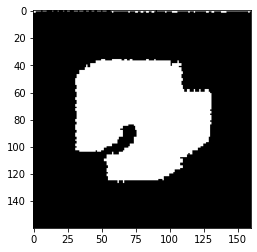

In [93]:

# plt.imshow(image_color)
# plt.savefig(SavePath + "contour" + str(i) + ".jpg")
H = computeHomography(np.float32(tag_corner), np.float32(desired_corner))
#tag = cv2.warpPerspective(image_transformed, H, (tag_size, tag_size))
tag = applyHomography2ImageUsingInverseWarping(np.uint8(image_transformed), H, (tag_size, tag_size))
tag = cv2.cvtColor(np.uint8(tag), cv2.COLOR_BGR2GRAY)
ret,tag = cv2.threshold(np.uint8(tag), 230 ,255,cv2.THRESH_BINARY)
plt.imshow(np.uint8(tag), cmap= 'gray')
plt.savefig(SavePath + "tag" + str(i) + ".jpg")


In [91]:
info = extractInfoFromTag(tag)
tag_id = decipherInfoFromTag(info)

100980
102000
102000
102000
102000
102000
102000
100980
102000
102000
92820
102000
[[  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0. 255. 255. 255.   0.   0.   0.]
 [  0.   0. 255. 255. 255. 255.   0.   0.]
 [  0.   0. 255.   0. 255. 255.   0.   0.]
 [  0.   0.   0. 255. 255.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]]
[[  0. 255. 255.   0.]
 [255. 255.   0. 255.]
 [255. 255. 255. 255.]
 [  0. 255. 255. 255.]]


In [92]:
tag_id

13

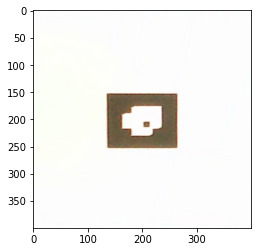

In [72]:
H = computeHomography(np.float32(corner1), np.float32(corner2))
image_transformed = cv2.warpPerspective(image, H, (size_x, size_y))
plt.imshow(image_transformed, cmap = 'gray')

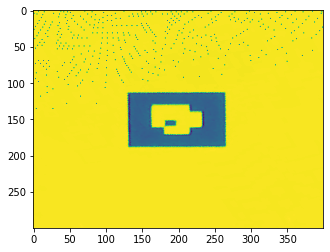

In [120]:

I = image
T = applyHomography2Image(I, H, (size_x, size_y))
plt.imshow(T)

In [99]:
h, w = I.shape[:2] 
Yi, Xi = np.indices((h, w)) 
lin_homg_pts = np.stack((Xi.ravel(), Yi.ravel(), np.ones(Xi.size)))

trans_lin_homg_pts = H.dot(lin_homg_pts)
trans_lin_homg_pts /= trans_lin_homg_pts[2,:]

In [103]:
lin_homg_pts.shape

(3, 2073600)

In [100]:
X_min = np.min(trans_lin_homg_pts[0,:])
Y_min = np.min(trans_lin_homg_pts[1,:])
X_max = np.max(trans_lin_homg_pts[0,:])
Y_max = np.max(trans_lin_homg_pts[1,:])

H_translate = np.array([[1, 0, -X_min], [0, 1, -Y_min], [0, 0, 1]])
 = H_translate.dot(trans_lin_homg_pts)

In [104]:
trans_lin_homg_pts.shape

(3, 2073600)

In [108]:
T = np.zeros((int(X_max - X_min) + 1, int(Y_max - Y_min) + 1))
x, y = trans_lin_homg_pts[:2,:].astype(int)
T[x, y] = I[Yi.ravel(), Xi.ravel()]

In [142]:
T

array([[252., 252., 253., ..., 255., 255., 255.],
       [252., 253., 253., ..., 255., 255., 255.],
       [252., 253., 253., ..., 253.,   0., 253.],
       ...,
       [252., 253., 253., ..., 253., 253., 253.],
       [252., 253., 253., ..., 253., 253., 253.],
       [252., 253., 253., ..., 253., 253., 253.]])

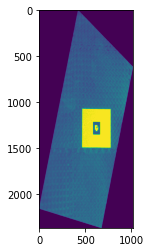

In [109]:
plt.imshow(T)

In [132]:
def applyHomography2Image(image, H, size):
    h, w = image.shape[:2] 
    Yi, Xi = np.indices((h, w)) 
    lin_homg_pts = np.stack((Xi.ravel(), Yi.ravel(), np.ones(Xi.size)))

    trans_lin_homg_pts = H.dot(lin_homg_pts)
    trans_lin_homg_pts /= trans_lin_homg_pts[2,:]

    X_min = np.min(trans_lin_homg_pts[0,:])
    Y_min = np.min(trans_lin_homg_pts[1,:])
    X_max = np.max(trans_lin_homg_pts[0,:])
    Y_max = np.max(trans_lin_homg_pts[1,:])

    H_translate = np.array([[1, 0, -X_min], [0, 1, -Y_min], [0, 0, 1]])
    #trans_lin_homg_pts = H_translate.dot(trans_lin_homg_pts)
   # trans_lin_homg_pts /= trans_lin_homg_pts[2,:]

    image_transformed = np.zeros((int(Y_max - Y_min) + 1, int(X_max - X_min) + 1))
    x, y = trans_lin_homg_pts[:2,:].astype(int)
    image_transformed[y, x] = image[Yi.ravel(), Xi.ravel()]
    image_cropped = image_transformed[0:size[1], 0:size[0]]

    return image_cropped


In [435]:
def applyHomography2ImageUsingInverseWarping(image, H, size):

    Xt, Yt = np.indices((size[0], size[1]))
    lin_homg_pts_trans = np.stack((Xt.ravel(), Yt.ravel(), np.ones(Xt.size)))

    H_inv = np.linalg.inv(H)
    lin_homg_pts = H_inv.dot(lin_homg_pts_trans)
    lin_homg_pts /= lin_homg_pts[2,:]

    X_min = np.min(lin_homg_pts[0,:]).astype(int)
    Y_min = np.min(lin_homg_pts[1,:]).astype(int)
    X_max = np.max(lin_homg_pts[0,:]).astype(int)
    Y_max = np.max(lin_homg_pts[1,:]).astype(int)
    X_min, X_max, Y_min, Y_max

    #pad image
    max_val = np.max([X_max, image.shape[0], Y_max, image.shape[1]])
    image_i = np.zeros((max_val, max_val))
    image_i[0:image.shape[0], 0:image.shape[1]] = image

    image_transformed = np.zeros((size[0], size[1]))
    Xi, Yi = lin_homg_pts[:2,:].astype(int)
    image_transformed[Xt.ravel(), Yt.ravel()] = image_i[Yi, Xi]
    
    return image_transformed


In [424]:
size = (400, 400)
Xt, Yt = np.indices((size[0], size[1]))
lin_homg_pts_trans = np.stack((Xt.ravel(), Yt.ravel(), np.ones(Xt.size)))




In [425]:
H_inv = np.linalg.inv(H)


In [426]:
lin_homg_pts = H_inv.dot(lin_homg_pts_trans)
lin_homg_pts /= lin_homg_pts[2,:]

In [427]:
X_min = np.min(lin_homg_pts[0,:]).astype(int)
Y_min = np.min(lin_homg_pts[1,:]).astype(int)
X_max = np.max(lin_homg_pts[0,:]).astype(int)
Y_max = np.max(lin_homg_pts[1,:]).astype(int)
X_min, X_max, Y_min, Y_max

(555, 1165, 344, 1122)

In [428]:
#pad image
max_val = np.max([X_max, image.shape[0], Y_max, image.shape[1]])
image_i = np.zeros((max_val, max_val))
# image_i = np.zeros((np.maximum(X_max, image.shape[0]), np.maximum(Y_max, image.shape[1])))
image_i[0:1080, 0:1920] = image

In [429]:
image_i.shape

(1920, 1920)

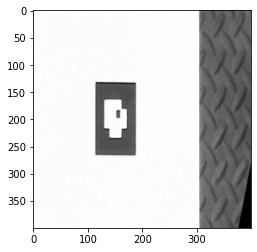

In [430]:
image_transformed = np.zeros((size[0], size[1]))
Xi, Yi = lin_homg_pts[:2,:].astype(int)

image_transformed[Xt.ravel(), Yt.ravel()] = image_i[Yi, Xi]
plt.imshow(image_transformed, cmap='gray')

In [385]:
np.max(Xi)

1077